In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/PTBJSON/largefloat.json'
filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/BinWikiAdjustedJSON/wikismallperf.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/WikiJSON/wikismallperfref.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/PTBJSON/ptbmedref.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/BinPTBAdjustedJSON/ptbsmallperf2.json'

t = time.time()
#Initialize lists to collect data
data = pd.read_json(filepath, orient='index')
namelist = []#; namelist2 = []
durlist = []
tslist = []
pidlist = []
description = []
req_mem = []
alloc_mem = []
oplist = []

#Description of every layer
#descrips = ['Cell 1', 'Cell 2', 'Loss', 'Embedding', 'Other Model', 'Test Input']
descrips = ['MatMul']
ignore = ['', 'Const', 'VariableV2', 'Identity', 'ArgMax', 'MEMCPYHtoD']
useid1 = -1
useid2 = -1

for key, value in data.items():
    #All events have attributes 'traceEvents' and 'name'
    event = value['traceEvents']
    name = event['name']
    pid = event['pid']
    
    #These attributes may not be in the event
    try: 
        args = event['args']
    except:
        args = {}
    try:
        dur = event['dur']
    except:
        dur = 0
    try:
        snapshot = args['snapshot']
    except:
        snapshot = {}
    try:
        tensord = snapshot['tensor_description']
    except:
        tensord = ''
    try:
        name2 = args['name']
    except:
        name2 = ''
    try:
        ts = event['ts']
    except:
        ts = 0
    try:
        op = args['op']
    except:
        op = ''
    try:
        pid = event['pid']
    except:
        pid = -1
        
    #Label events associated with important layer
    descrip = ''
    if name.find('cell_0') >= 0 or name2.find('cell_0') >= 0:
        descrip = 'Cell 1'
    elif name.find('cell_1') >= 0 or name2.find('cell_1') >= 0:
        descrip = 'Cell 2'
    elif name.find('sequence_loss_by_example') >= 0 or name2.find('sequence_loss_by_example') >= 0:
        descrip = 'Loss'
    elif name.find('embedding') >= 0 or name2.find('embedding') >= 0:
        descrip = 'Embedding'
    elif name.find('Model') >= 0 or name2.find('Model') >= 0:
        descrip = 'Other Model'
    elif name.find('TestInput') >= 0 or name2.find('TestInput') >= 0:
        descrip = 'Test Input'
    
    if name.find('MatMul') >= 0 or name2.find('MatMul') >= 0:
        descrip = 'MatMul'
    
    #Add data to lists
    #namelist.append(name)
    durlist.append(dur)
    description.append(descrip)
    tslist.append(ts)
    namelist.append(name)
    oplist.append(op)
    pidlist.append(pid)
    
    if name2 == '/job:localhost/replica:0/task:0/gpu:0 Tensors':
        useid1 = pid
    if name2 == '/gpu:0/stream:all Compute':
        useid2 = pid
    
    #Find memory information if present
    indr = tensord.find('requested_bytes')
    inda = tensord.find('allocated_bytes')
    indend = tensord.find('allocator_name')

    req_bytes = 0
    alloc_bytes = 0
    if indr >= 0:
        indr += 17
        if inda >= 0:
            req_bytes = int(tensord[indr:inda].replace('\n', '').strip())
        else:
            req_bytes = int(tensord[indr:indend].replace('\n', '').strip())
    if inda >= 0:
        inda += 17
        alloc_bytes = int(tensord[inda: indend].replace('\n', '').strip())

    req_mem.append(req_bytes)
    alloc_mem.append(alloc_bytes)

#Create a dataframe with all relevant data
df = pd.DataFrame({'Description': description, 'pid': pidlist, 'Op': oplist, 'Name': namelist, 'Dur': durlist, 'Req. Mem.': req_mem, 'Alloc. Mem.': alloc_mem, 'TS': tslist})

#Only look at data which will contribute to runtime or memory
df = df[(df['Dur'] > 0) | (df['Alloc. Mem.'] > 0) | (df['Req. Mem.'] > 0)]
totdur = df['Dur'][df['pid'] == useid2].sum()
print(totdur)

#Extract summary statistics
df2 = pd.DataFrame({})
crittime=0
for s in descrips:
    df1 = df[(df['Description'] == s) & ((df['pid'] == useid2) | (df['pid'] == useid2))]
    #dfname1 = dfname[dfname['Description'] == s]
    dfnomem = df1[~df1.Op.isin(ignore)]
    #print(dfnomem)
    dfdur = df.sort_values(by=['TS'])
    dfts = dfdur['TS']
    #print(dfdur)
    crittime = 0
    if len(dfts.index) > 0:
        crittime = dfts.iloc[len(dfts.index)-1]-dfts.iloc[0]
        crittime += dfdur['Dur'].iloc[len(dfdur.index)-1]
        #print(s, crittime)
    
    sum1 = df1.sum(axis = 0)
    #print(sum1)
    critframe = pd.DataFrame(index=['Crit'], data=[crittime])
    sum1 = pd.concat([sum1, critframe])
    #print(sum1)
    #am1 = sum1['Alloc. Mem.']
    #dur1 = sum1['Dur']
    df2 = pd.concat([df2, sum1], axis=1)
df2.columns = descrips
df2 = df2.drop(['Description', 'Name', 'Op', 'TS', 'pid', 'Crit'])
print(df2)
print(crittime)
freq = 800
freq = 1000
#print(df2/169*169568/crittime)
print(df2*freq)
print(df2*freq/crittime)
print(df2/totdur)
#df2 = df2.drop('Cross Entropy', 1)
#df2.to_csv('lstm1000output.csv', mode='w', header=True)
#df2/85

105761
            MatMul
Alloc. Mem.      0
Dur          36689
Req. Mem.        0
876895360
               MatMul
Alloc. Mem.         0
Dur          36689000
Req. Mem.           0
                MatMul
Alloc. Mem.          0
Dur          0.0418397
Req. Mem.            0
               MatMul
Alloc. Mem.         0
Dur          0.346905
Req. Mem.           0


Cell 1         137.037012
Cell 2         137.036800
Loss             2.121060
Embedding      480.024000
Other Model    856.608896
Test Input      17.481228
Name: Req. Mem., dtype: float64 mb 

Cell 1         137.335296
Cell 2         137.294080
Loss             3.568384
Embedding      503.347200
Other Model    859.532800
Test Input      21.301760
Name: Alloc. Mem., dtype: float64 mb 

Cell 1         8.680
Cell 2         8.690
Loss           9.574
Embedding      0.000
Other Model    7.891
Test Input     0.000
Name: Dur, dtype: float64 ms


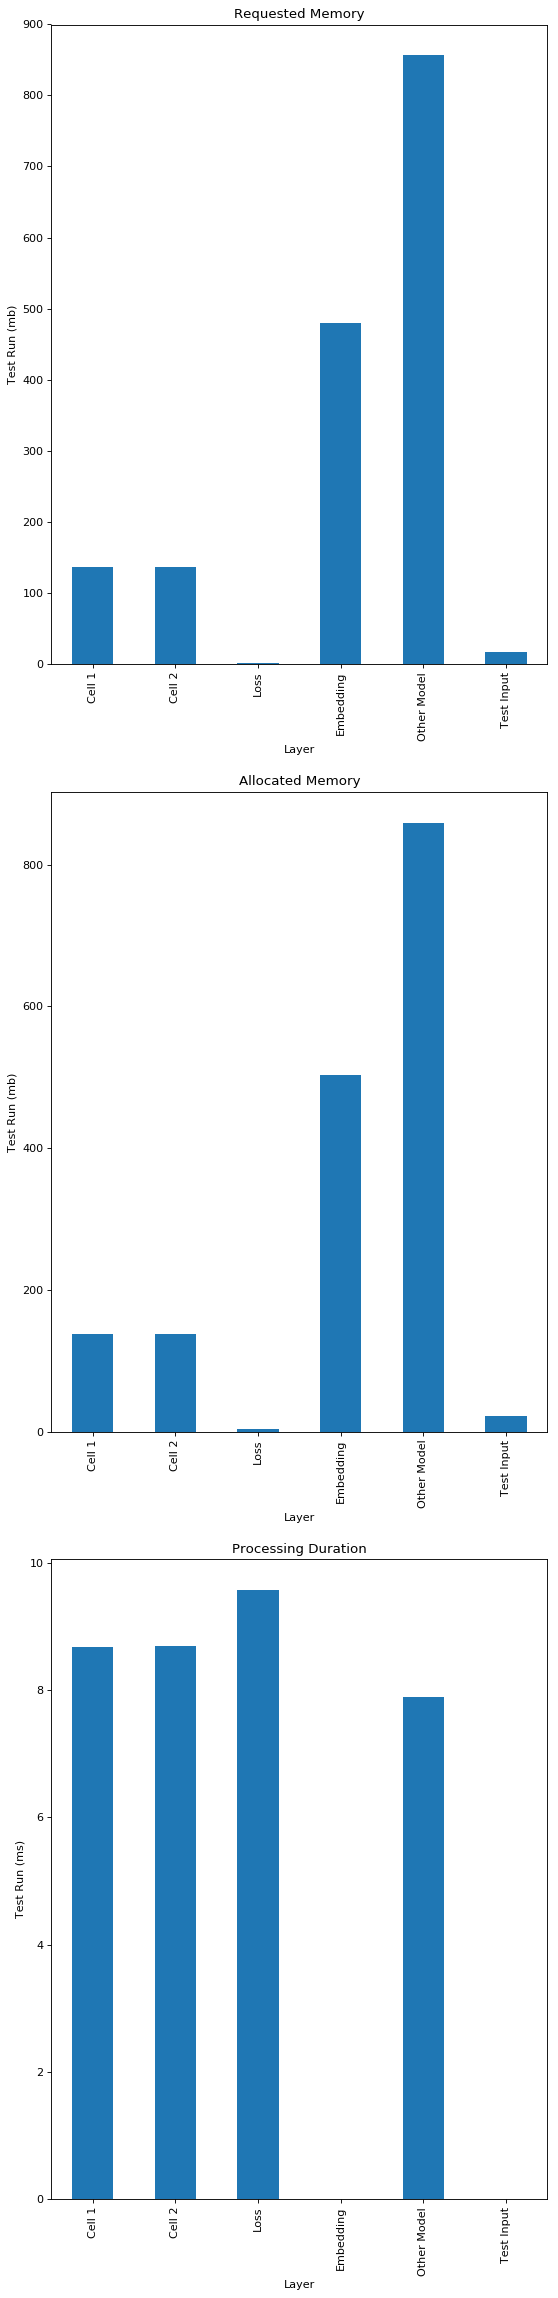

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

outputpath = 'C:/Users/bzh08/Documents/TensorFlow Programs/Jupyter Files/lstm1000output.csv'
dfpost = pd.read_csv(outputpath, index_col=0)
#print(dfpost)
#dfpost = dfpost.drop('Accuracy', 1)
#print(dfpost)
size = 1

finalreqm = dfpost.loc['Req. Mem.'].sum()/size/10**6
finalreqm = dfpost.loc['Req. Mem.']/size/10**6
finalallm = dfpost.loc['Alloc. Mem.'].sum()/size/10**6
finalallm = dfpost.loc['Alloc. Mem.']/size/10**6
finaldur = dfpost.loc['Dur'].sum()/10**3/size
finaldur = dfpost.loc['Dur']/10**3/size
print(finalreqm, 'mb', '\n')
print(finalallm, 'mb', '\n')
print(finaldur, 'ms')

fig=plt.figure(figsize=(8, 36), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(3, 1, 1)
ax1 = finalreqm.plot(kind='bar')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Test Run (mb)')
ax1.set_title('Requested Memory')

plt.subplot(3, 1, 2)
ax2 = finalallm.plot(kind='bar')
ax2.set_xlabel('Layer')
ax2.set_ylabel('Test Run (mb)')
ax2.set_title('Allocated Memory')

plt.subplot(3, 1, 3)
ax3 = finaldur.plot(kind='bar')
ax3.set_xlabel('Layer')
ax3.set_ylabel('Test Run (ms)')
ax3.set_title('Processing Duration')

plt.show()

In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, HTML

#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/PTBJSON/largefloat.json'
filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/BinWikiAdjustedJSON/wikilargeperf.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/WikiJSON/wikismallperfref.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/PTBJSON/ptbmedref.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/BinPTBAdjustedJSON/ptbsmallperf.json'

t = time.time()
#Initialize lists to collect data
data = pd.read_json(filepath, orient='index')
namelist = []#; namelist2 = []
durlist = []
tslist = []
pidlist = []
description = []
req_mem = []
alloc_mem = []
oplist = []

#Description of every layer
#descrips = ['Cell 1', 'Cell 2', 'Loss', 'Embedding', 'Other Model', 'Test Input']
descrips = ['MatMul']
ignore = ['', 'Const', 'VariableV2', 'Identity', 'ArgMax', 'MEMCPYHtoD']
useid1 = -1
useid2 = -1

for key, value in data.items():
    #All events have attributes 'traceEvents' and 'name'
    event = value['traceEvents']
    name = event['name']
    pid = event['pid']
    
    #These attributes may not be in the event
    try: 
        args = event['args']
    except:
        args = {}
    try:
        dur = event['dur']
    except:
        dur = 0
    try:
        snapshot = args['snapshot']
    except:
        snapshot = {}
    try:
        tensord = snapshot['tensor_description']
    except:
        tensord = ''
    try:
        name2 = args['name']
    except:
        name2 = ''
    try:
        ts = event['ts']
    except:
        ts = 0
    try:
        op = args['op']
    except:
        op = ''
    try:
        pid = event['pid']
    except:
        pid = -1
        
    #Label events associated with important layer
    descrip = ''
    if name.find('cell_0') >= 0 or name2.find('cell_0') >= 0:
        descrip = 'Cell 1'
    elif name.find('cell_1') >= 0 or name2.find('cell_1') >= 0:
        descrip = 'Cell 2'
    elif name.find('sequence_loss_by_example') >= 0 or name2.find('sequence_loss_by_example') >= 0:
        descrip = 'Loss'
    elif name.find('embedding') >= 0 or name2.find('embedding') >= 0:
        descrip = 'Embedding'
    elif name.find('Model') >= 0 or name2.find('Model') >= 0:
        descrip = 'Other Model'
    elif name.find('TestInput') >= 0 or name2.find('TestInput') >= 0:
        descrip = 'Test Input'
    
    if name.find('MatMul') >= 0 or name2.find('MatMul') >= 0:
        descrip = 'MatMul'
    
    #Add data to lists
    #namelist.append(name)
    durlist.append(dur)
    description.append(descrip)
    tslist.append(ts)
    namelist.append(name)
    oplist.append(op)
    pidlist.append(pid)
    
    if name2 == '/job:localhost/replica:0/task:0/gpu:0 Tensors':
        useid1 = pid
    if name2 == '/gpu:0/stream:all Compute':
        useid2 = pid
    
    #Find memory information if present
    indr = tensord.find('requested_bytes')
    inda = tensord.find('allocated_bytes')
    indend = tensord.find('allocator_name')

    req_bytes = 0
    alloc_bytes = 0
    if indr >= 0:
        indr += 17
        if inda >= 0:
            req_bytes = int(tensord[indr:inda].replace('\n', '').strip())
        else:
            req_bytes = int(tensord[indr:indend].replace('\n', '').strip())
    if inda >= 0:
        inda += 17
        alloc_bytes = int(tensord[inda: indend].replace('\n', '').strip())

    req_mem.append(req_bytes)
    alloc_mem.append(alloc_bytes)

#Create a dataframe with all relevant data
df = pd.DataFrame({'Description': description, 'pid': pidlist, 'Op': oplist, 'Name': namelist, 'Dur': durlist, 'Req. Mem.': req_mem, 'Alloc. Mem.': alloc_mem, 'TS': tslist})
#print(df[(df['Op'] != '') & (df['pid'] == useid2)])

#Only look at data which will contribute to runtime or memory
df = df[(df['Dur'] > 0) | (df['Alloc. Mem.'] > 0) | (df['Req. Mem.'] > 0)]
df = df[(df['Op'] != '') & (df['pid'] == useid2)]

durdict = {}
kernels = set(df['Op'])
for k in kernels:
    kernelsum = df[df['Op'] == k]['Dur'].sum()
    if k == 'SparseSoftmaxCrossEntropyWithLogits':
        k = 'CrossEntropy'
    durdict[k] = kernelsum
durtable = pd.DataFrame.from_dict(durdict, orient='index')
durtable = durtable.sort_values(by=[0], ascending=[False])

totdur = df['Dur'][df['pid'] == useid2].sum()
print(totdur)

print(durtable/totdur*100)

#Extract summary statistics
df2 = pd.DataFrame({})
crittime=0
for s in descrips:
    df1 = df[(df['Description'] == s) & ((df['pid'] == useid2) | (df['pid'] == useid2))]
    dfnomem = df1[~df1.Op.isin(ignore)]
    dfdur = df.sort_values(by=['TS'])
    dfts = dfdur['TS']
    crittime = 0
    if len(dfts.index) > 0:
        crittime = dfts.iloc[len(dfts.index)-1]-dfts.iloc[0]
        crittime += dfdur['Dur'].iloc[len(dfdur.index)-1]   
    sum1 = df1.sum(axis = 0)
    critframe = pd.DataFrame(index=['Crit'], data=[crittime])
    sum1 = pd.concat([sum1, critframe])
    df2 = pd.concat([df2, sum1], axis=1)
    
df2.columns = descrips
df2 = df2.drop(['Description', 'Name', 'TS', 'pid', 'Crit'])
print(df2)
print(crittime)
freq = 800
freq = 1000

#crittime = 141.37*1e6
#crittime = 167.38*1e6
#crittime = 236.43*1e6
crittime = 370.77*1e6
crittime = 436.59*1e6
crittime = 514.92*1e6
#print(durtable*freq/crittime*100)
durtable.columns = ['% Wall Time']
display(durtable*freq/crittime*100)

188677
                      0
MatMul        72.604504
CrossEntropy  14.757496
Sigmoid        2.703562
Mul            2.552510
Add            2.000244
Tanh           1.626059
Split          1.622349
BiasAdd        0.864440
RealDiv        0.843770
Unpack         0.425065
                                                        MatMul
Alloc. Mem.                                                  0
Dur                                                     136988
Op           MatMulMatMulMatMulMatMulMatMulMatMulMatMulMatM...
Req. Mem.                                                    0
1048413935


,% Wall Time
MatMul,26.603744
CrossEntropy,5.407442
Sigmoid,0.990639
Mul,0.935291
Add,0.732929
Tanh,0.595821
Split,0.594461
BiasAdd,0.316748
RealDiv,0.309174
Unpack,0.155752


In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, HTML

#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/PTBJSON/largefloat.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/BinWikiAdjustedJSON/wikilargeperf.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/WikiJSON/wikismallperfref.json'
#filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/PTBJSON/ptbmedref.json'
filepath = 'C:/Users/bzh08/Documents/TensorFlow Programs/BinPTBAdjustedJSON/ptbsmallperf.json'

t = time.time()
#Initialize lists to collect data
data = pd.read_json(filepath, orient='index')
namelist = []#; namelist2 = []
durlist = []
tslist = []
pidlist = []
description = []
req_mem = []
alloc_mem = []
oplist = []

#Description of every layer
#descrips = ['Cell 1', 'Cell 2', 'Loss', 'Embedding', 'Other Model', 'Test Input']
descrips = ['MatMul']
#ignore = ['', 'Const', 'VariableV2', 'Identity', 'ArgMax', 'MEMCPYHtoD']
ignore = []
useid1 = -1
useid2 = -1
useid3 = -1

for key, value in data.items():
    #All events have attributes 'traceEvents' and 'name'
    event = value['traceEvents']
    name = event['name']
    pid = event['pid']
    
    #These attributes may not be in the event
    try: 
        args = event['args']
    except:
        args = {}
    try:
        dur = event['dur']
    except:
        dur = 0
    try:
        snapshot = args['snapshot']
    except:
        snapshot = {}
    try:
        tensord = snapshot['tensor_description']
    except:
        tensord = ''
    try:
        name2 = args['name']
    except:
        name2 = ''
    try:
        ts = event['ts']
    except:
        ts = 0
    try:
        op = args['op']
    except:
        op = ''
    try:
        pid = event['pid']
    except:
        pid = -1
        
    #Label events associated with important layer
    descrip = ''
    if name.find('cell_0') >= 0 or name2.find('cell_0') >= 0:
        descrip = 'Cell 1'
    elif name.find('cell_1') >= 0 or name2.find('cell_1') >= 0:
        descrip = 'Cell 2'
    elif name.find('sequence_loss_by_example') >= 0 or name2.find('sequence_loss_by_example') >= 0:
        descrip = 'Loss'
    elif name.find('embedding') >= 0 or name2.find('embedding') >= 0:
        descrip = 'Embedding'
    elif name.find('Model') >= 0 or name2.find('Model') >= 0:
        descrip = 'Other Model'
    elif name.find('TestInput') >= 0 or name2.find('TestInput') >= 0:
        descrip = 'Test Input'
    
    if name.find('MatMul') >= 0 or name2.find('MatMul') >= 0:
        descrip = 'MatMul'
    
    #Add data to lists
    #namelist.append(name)
    durlist.append(dur)
    description.append(descrip)
    tslist.append(ts)
    namelist.append(name)
    oplist.append(op)
    pidlist.append(pid)
    
    if name2 == '/job:localhost/replica:0/task:0/gpu:0 Tensors':
        useid1 = pid
    if name2 == '/gpu:0/stream:all Compute':
        useid2 = pid
    if name2 == '/gpu:0/memcpy Compute':
        useid3 = pid
    
    #Find memory information if present
    indr = tensord.find('requested_bytes')
    inda = tensord.find('allocated_bytes')
    indend = tensord.find('allocator_name')

    req_bytes = 0
    alloc_bytes = 0
    if indr >= 0:
        indr += 17
        if inda >= 0:
            req_bytes = int(tensord[indr:inda].replace('\n', '').strip())
        else:
            req_bytes = int(tensord[indr:indend].replace('\n', '').strip())
    if inda >= 0:
        inda += 17
        alloc_bytes = int(tensord[inda: indend].replace('\n', '').strip())

    req_mem.append(req_bytes)
    alloc_mem.append(alloc_bytes)

#Create a dataframe with all relevant data
df = pd.DataFrame({'Description': description, 'pid': pidlist, 'Op': oplist, 'Name': namelist, 'Dur': durlist, 'Req. Mem.': req_mem, 'Alloc. Mem.': alloc_mem, 'TS': tslist})
#print(df[(df['Op'] != '') & (df['pid'] == useid2)])
df = df[(df['Op'] == 'MEMCPYHtoDN') | (df['Op'] == 'MEMCPYDtoHNOT') | (df['Op'] == 'MEMCPYDtoD')]
#Only look at data which will contribute to runtime or memory
df = df[(df['Dur'] > 0) | (df['Alloc. Mem.'] > 0) | (df['Req. Mem.'] > 0)]
df = df[df['pid'] == useid3]

freq = 800
freq = 1000

print(df)
print(df['Dur'].sum()*800)

Empty DataFrame
Columns: [Alloc. Mem., Description, Dur, Name, Op, Req. Mem., TS, pid]
Index: []
0
